## Visualizing various Model Selection chain outputs

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle
import enterprise.signals.utils as utils

In [3]:
import sys
sys.path.insert(0,'/Users/hazboun/software_development/la_forge/')
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

In [4]:
psrname = 'J1911+1347'#'J1600-3053'#
chaindir = '/Users/hazboun/nanograv_detection/ent_ext_testing/{}/nondiag_dmgp/'.format(psrname)

In [5]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 13275
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


In [6]:
vals,bins=np.histogram(cH.get_param('nmodel'),bins=[-0.5,0.5,1.5,2.5,3.5])
np.argmax(vals)

3

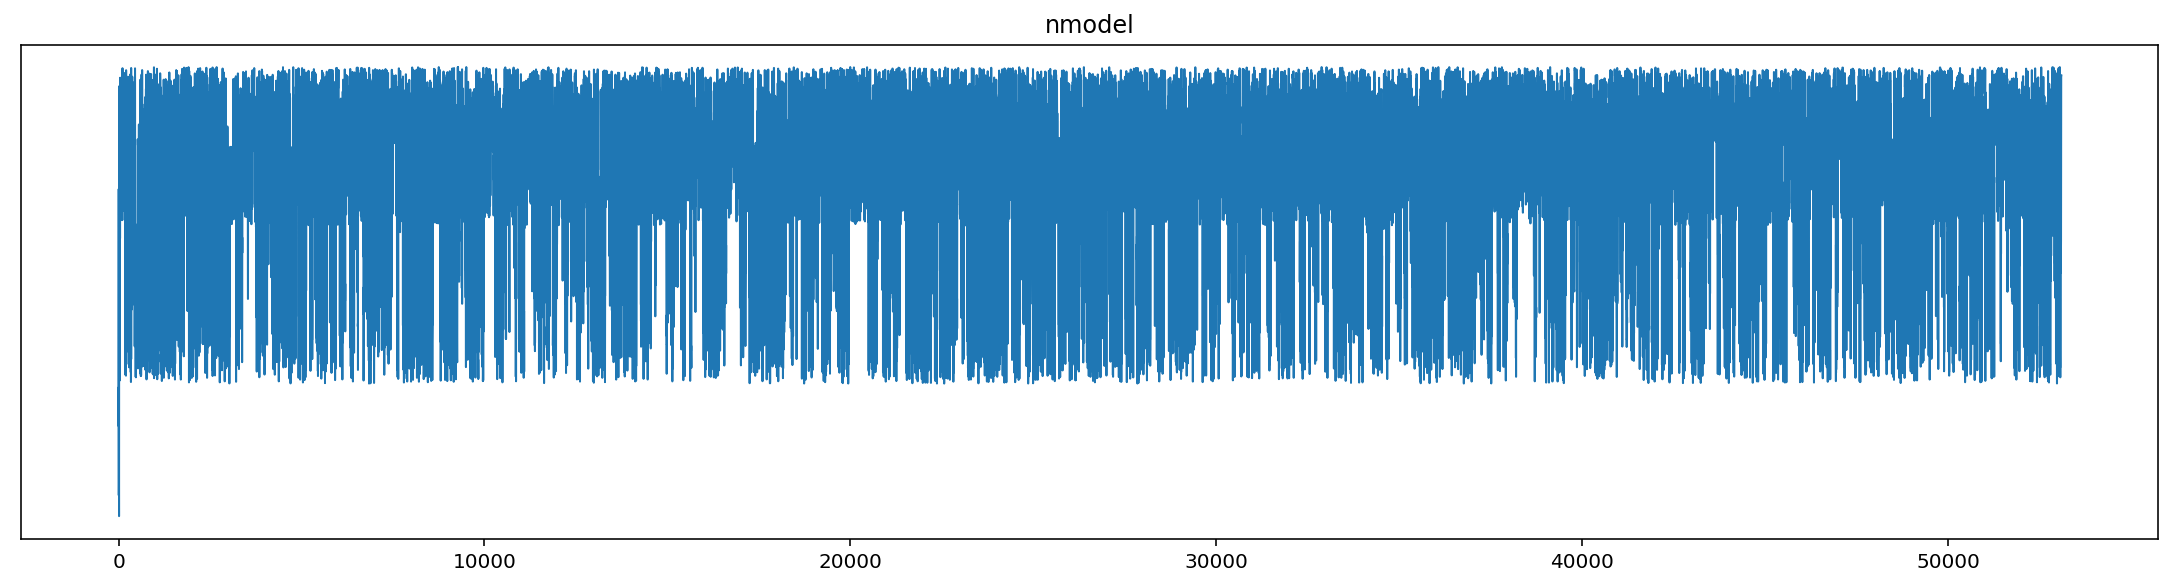

In [7]:
dg.plot_chains(cH,hist=False,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='',)

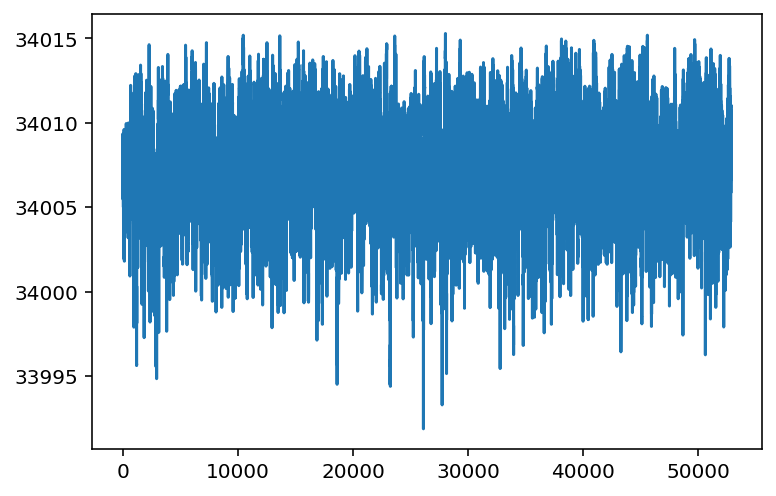

In [8]:
plt.plot(cH.get_param('lnlike',to_burn=False)[250:])
plt.show()

In [9]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'powerlaw', 'None', True],
 ['B', 'powerlaw', 'None', False],
 ['C', 'powerlaw', 'sq_exp', True],
 ['D', 'powerlaw', 'sq_exp', False],
 ['E', 'powerlaw', 'periodic', True],
 ['F', 'powerlaw', 'periodic', False]]

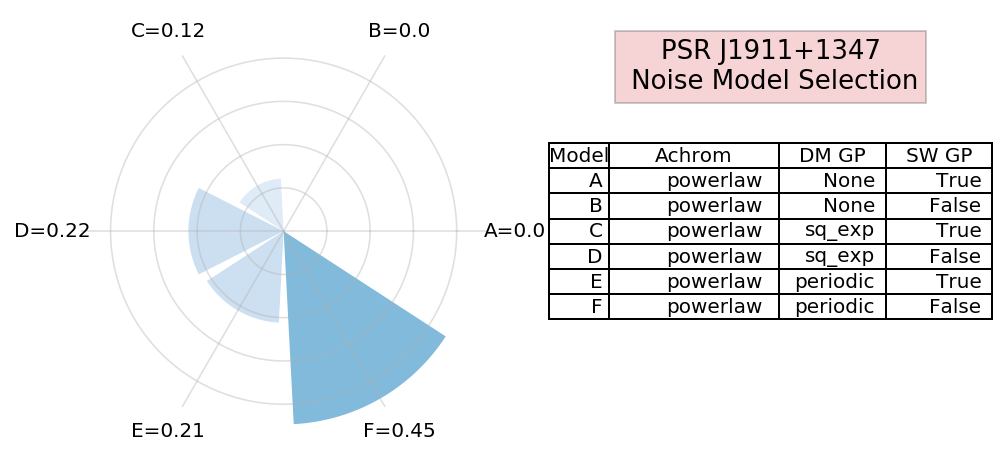

In [10]:
dg.noise_flower(cH, 
                colLabels=['Model','Achrom', 'DM GP', 'SW GP'],
                #['Model','DM GP','ChromGP', 'ChromIdx'],
                cellText=model_labels,
                colWidths=[0.14,0.4,0.25,0.25])

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters

In [11]:
c0=cH.model_core(0)
c1=cH.model_core(1)
c2=cH.model_core(2)
c3=cH.model_core(3)
# c4=cH.model_core(4)
c5=cH.model_core(5)

In [12]:
c3.params

['J1911+1347_430_PUPPI_efac',
 'J1911+1347_430_PUPPI_log10_ecorr',
 'J1911+1347_430_PUPPI_log10_equad',
 'J1911+1347_L-wide_PUPPI_efac',
 'J1911+1347_L-wide_PUPPI_log10_ecorr',
 'J1911+1347_L-wide_PUPPI_log10_equad',
 'J1911+1347_dm_gp_log10_ell',
 'J1911+1347_dm_gp_log10_sigma',
 'J1911+1347_red_noise_gamma',
 'J1911+1347_red_noise_log10_A',
 'n_earth',
 'lnlike',
 'lnprior',
 'chain_accept',
 'pt_chain_accept']

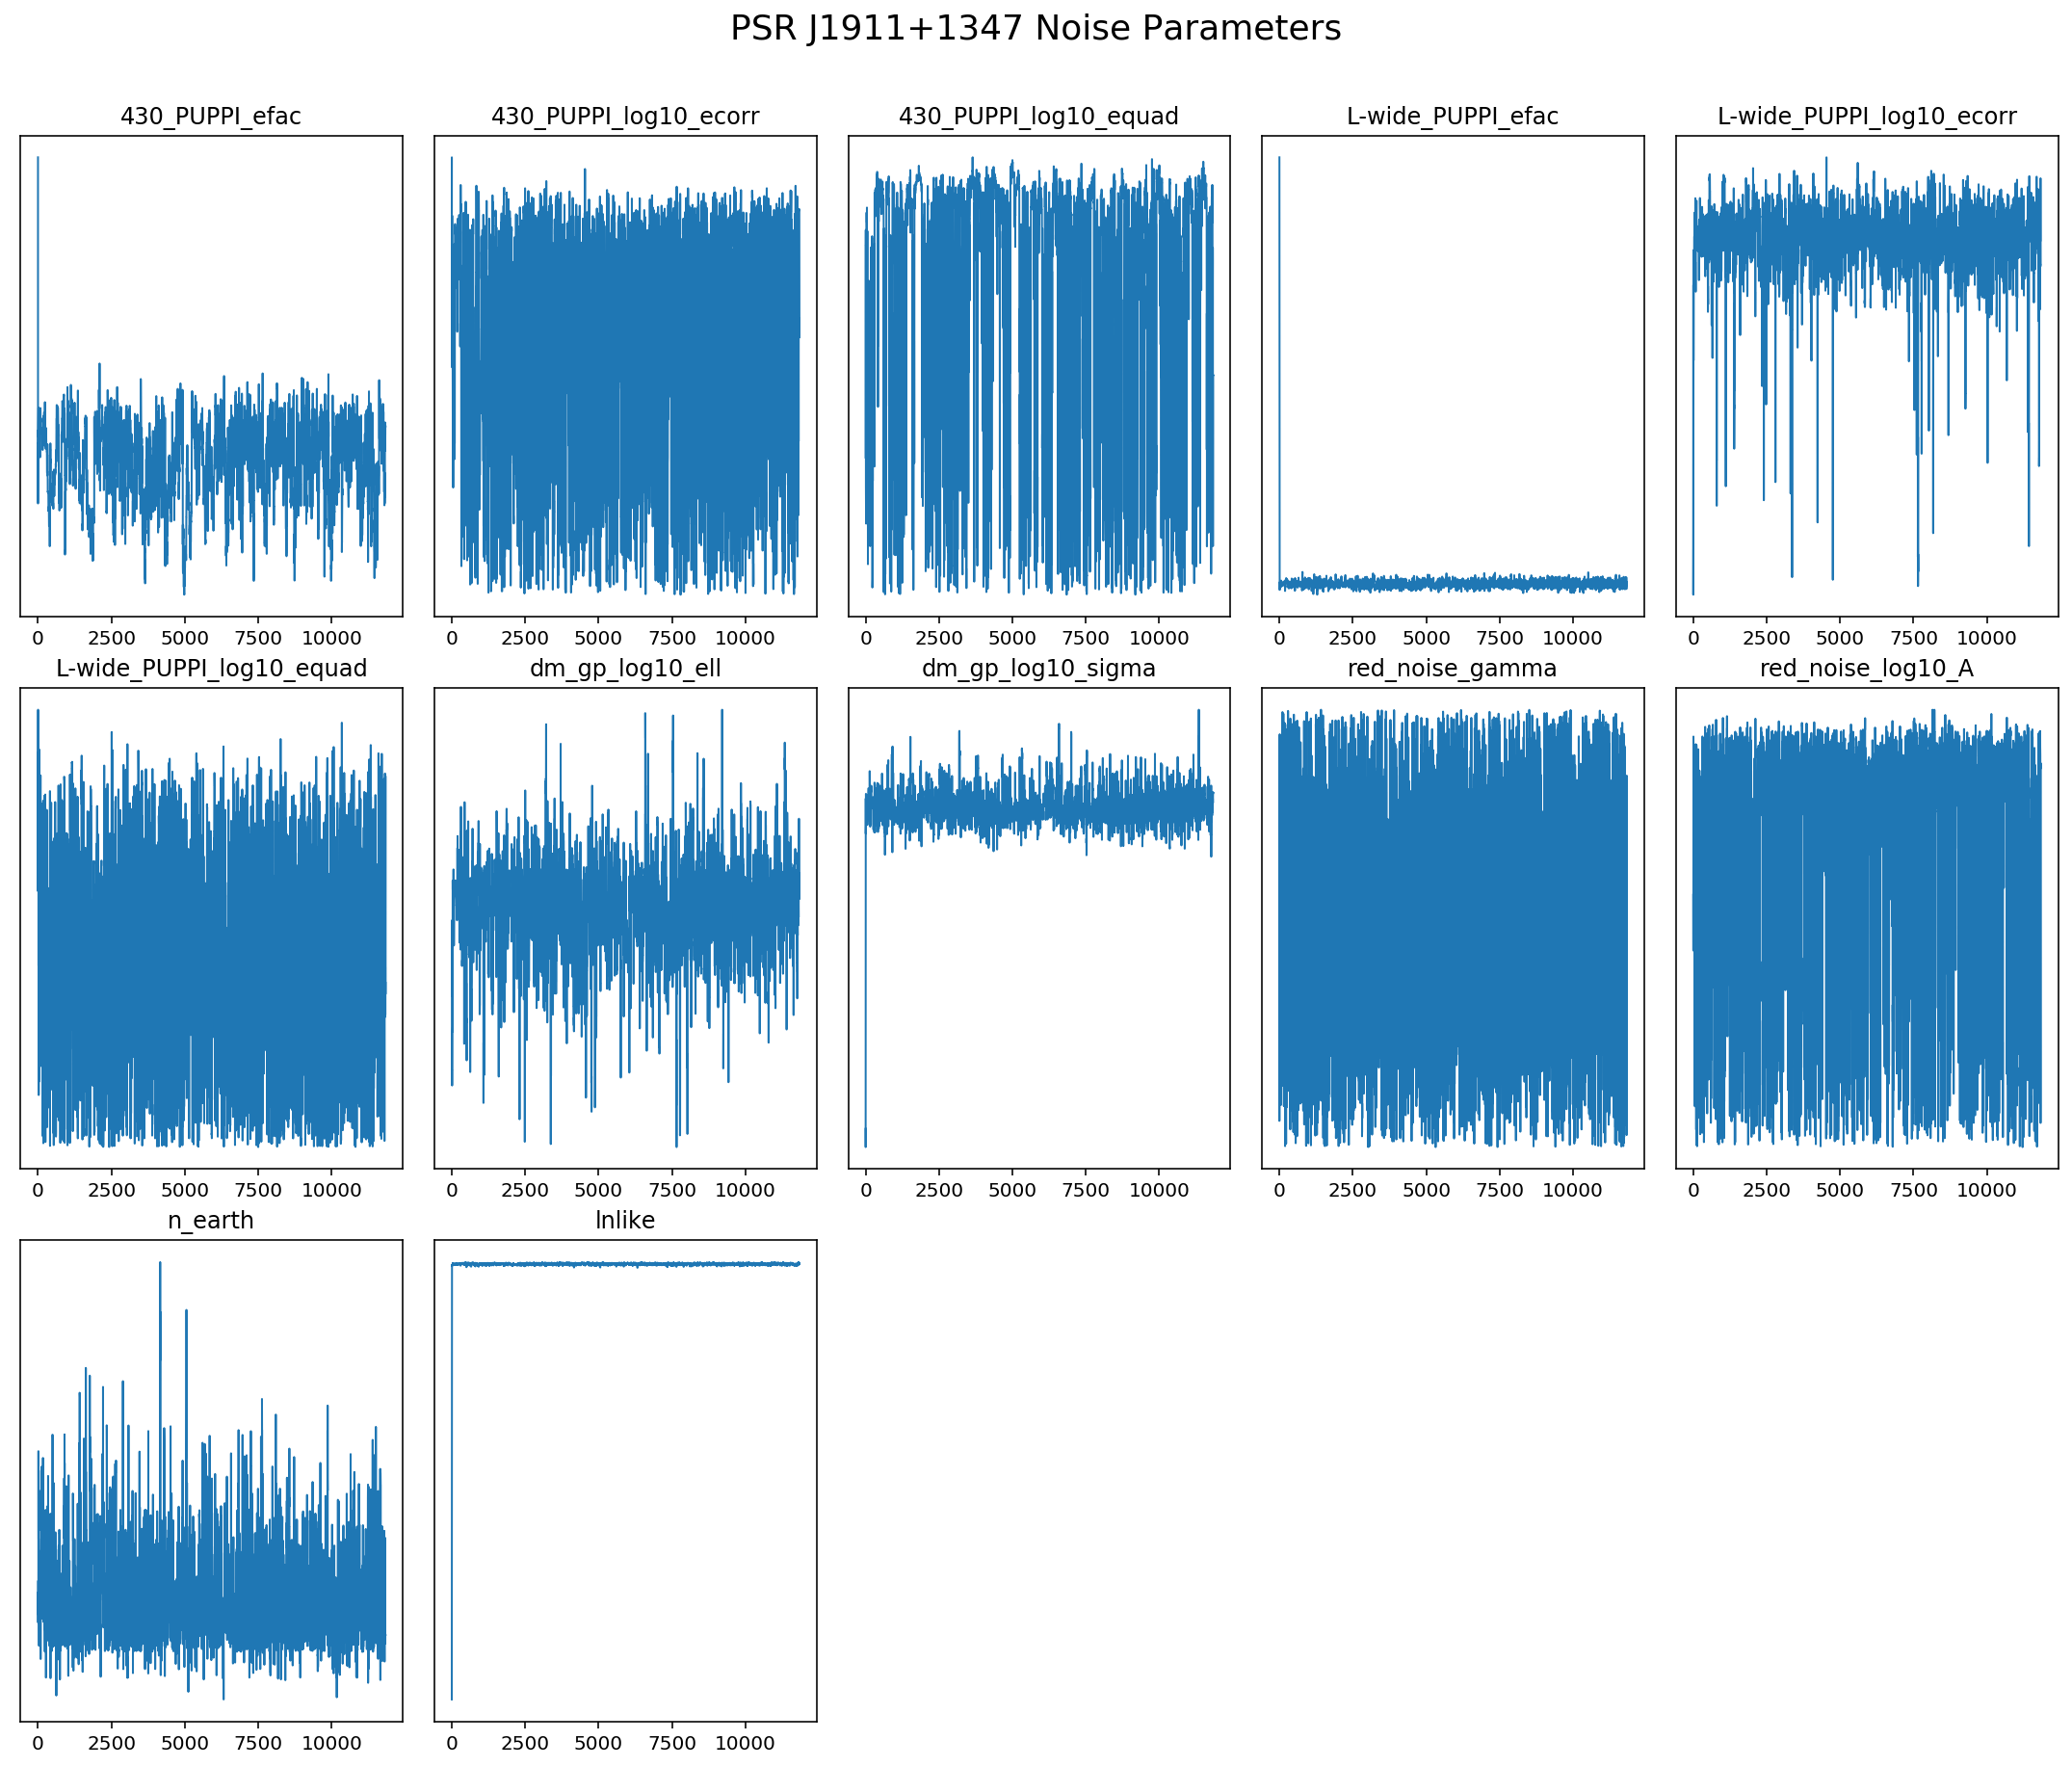

In [13]:
dg.plot_chains(c3, hist=False, ncols=5, title_y=1.05,
               exclude=['lnprior', 'chain_accept', 'pt_chain_accept'])

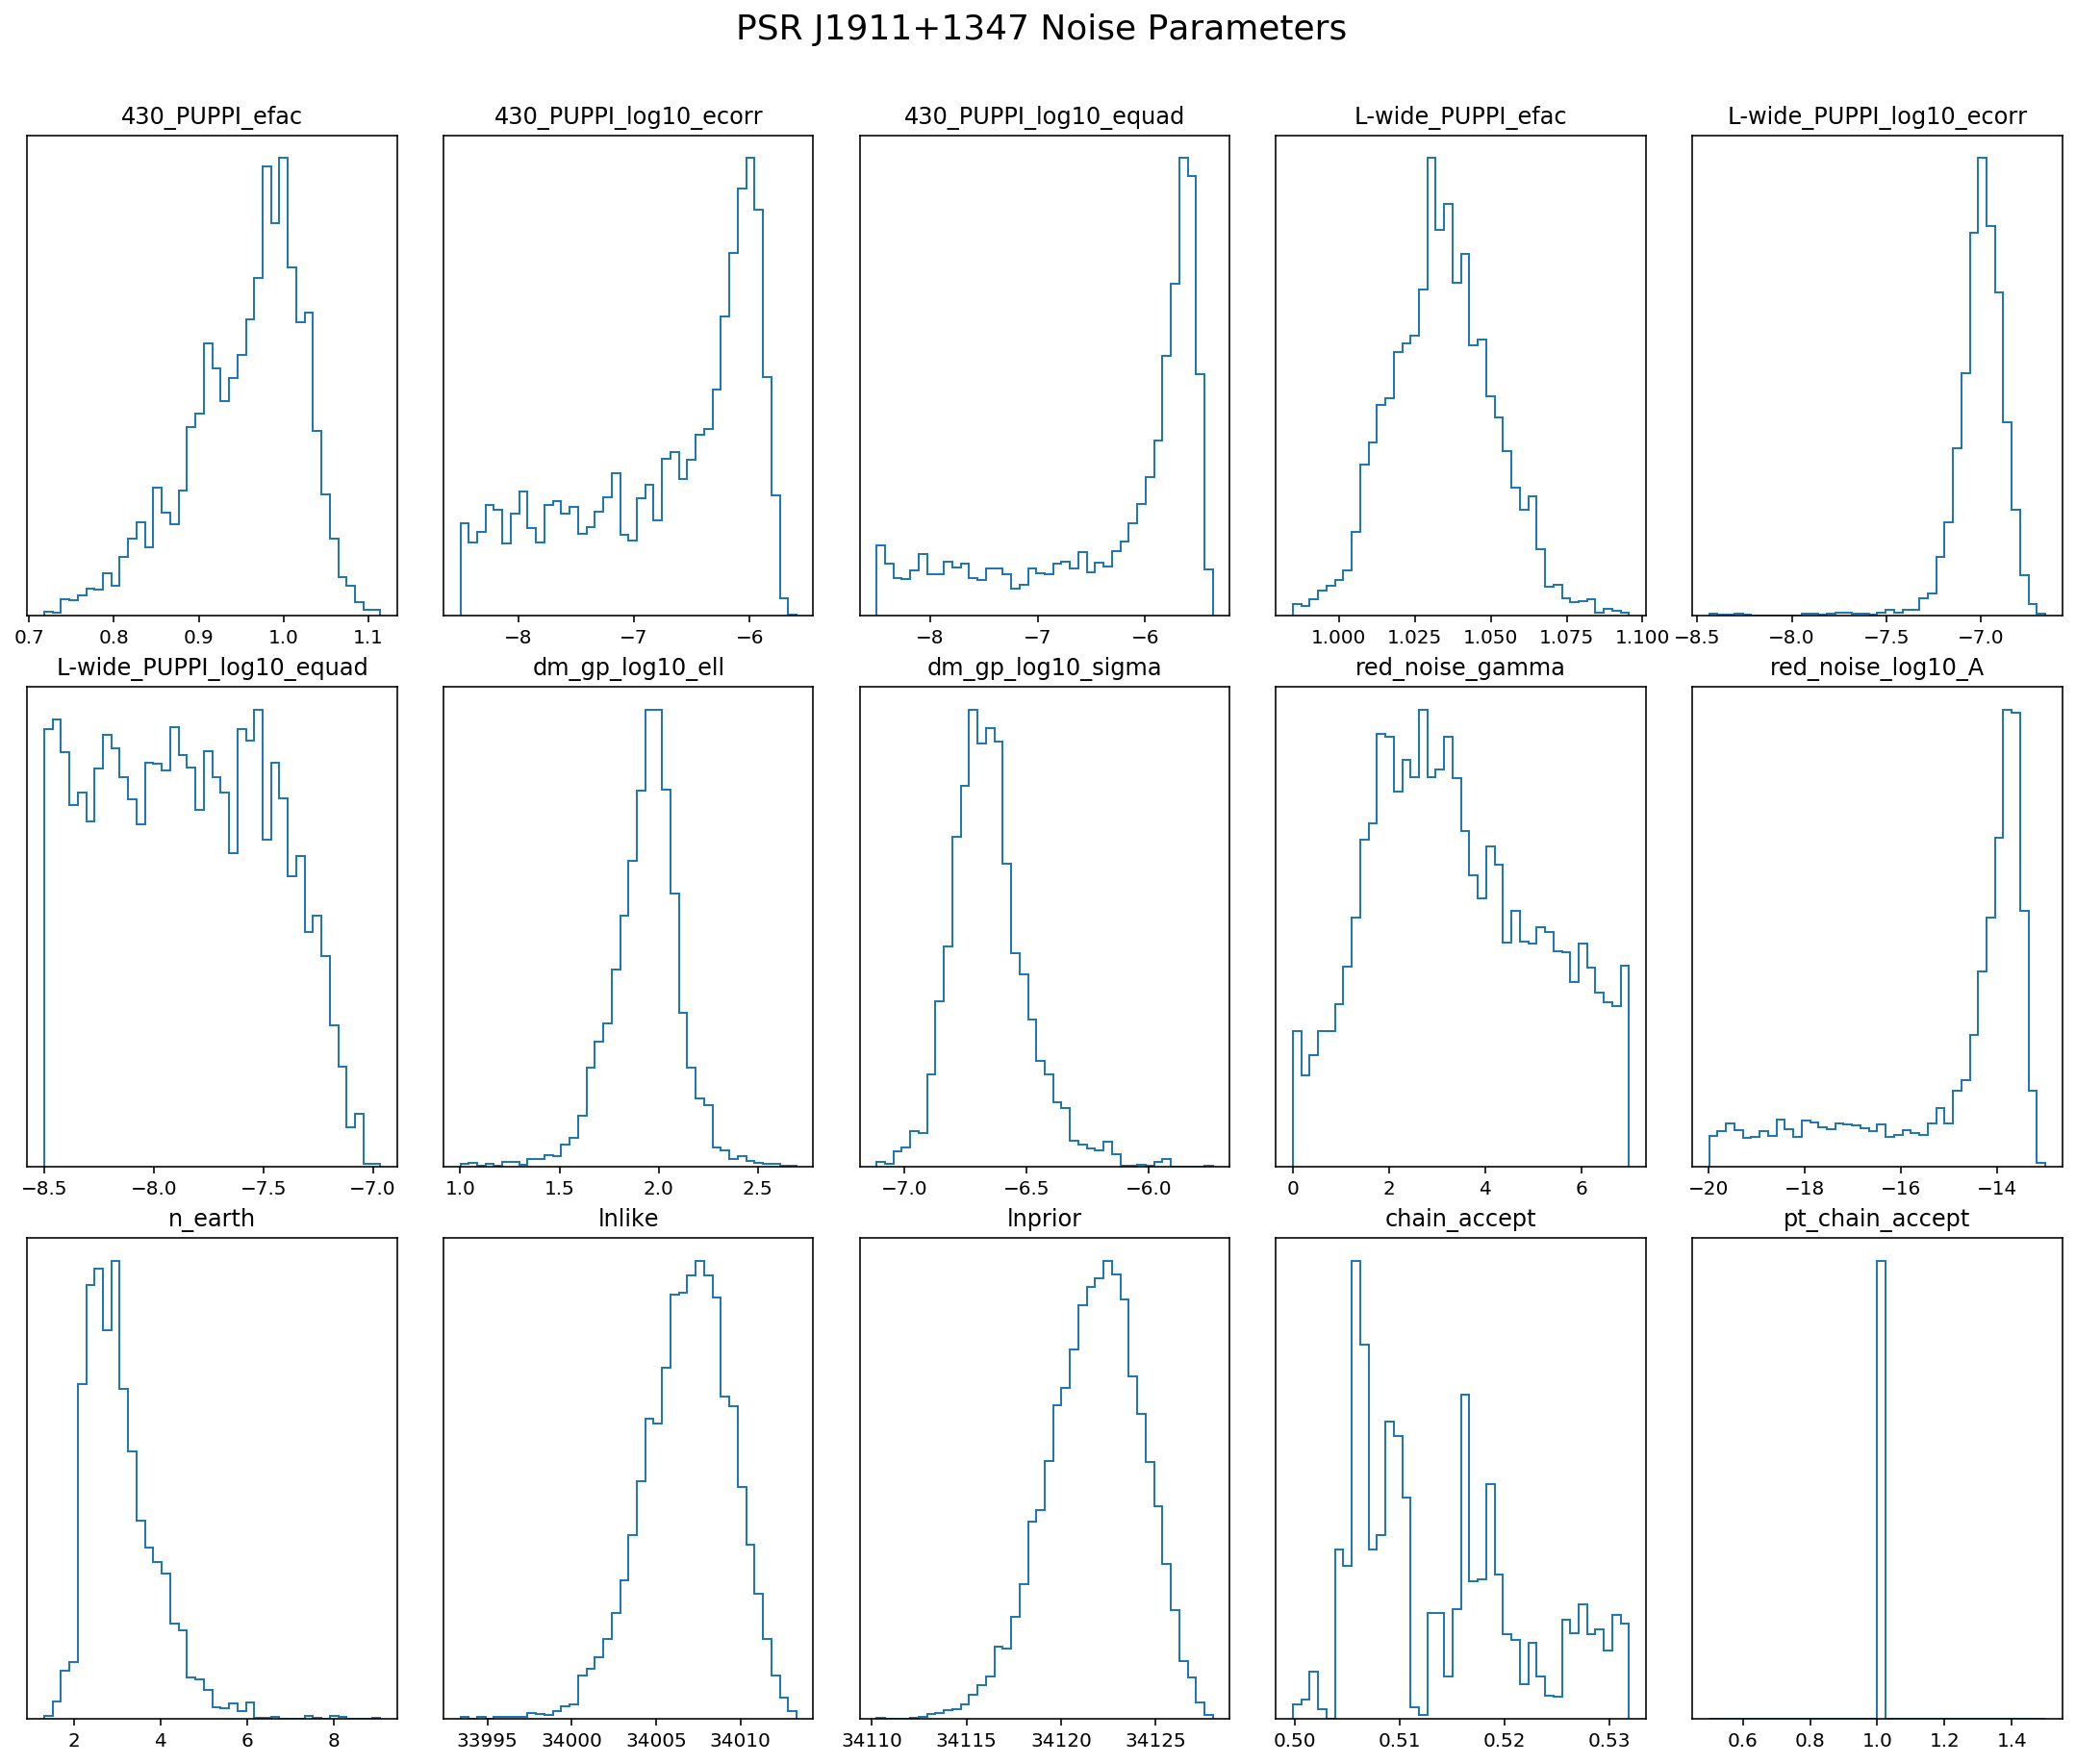

In [14]:
dg.plot_chains(c3, hist=True, ncols=5, title_y=1.05)

# Gaussian Process Realizations

In [15]:
from enterprise_extensions.models import model_singlepsr_noise

In [16]:
from la_forge.gp import Signal_Reconstruction as gp

In [17]:
# psrname = 'J1911+1347'
filepath = './no_dmx_pickles/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)

In [18]:
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_kwargs=json.load(fin)

In [19]:
# model_kwargs['5'].__delitem__('dmchrom_idx')
# model_kwargs['5'].__delitem__('dmchrom_psd')
# model_kwargs['5'].__delitem__('dm_chrom')
# model_kwargs['5'].__delitem__('dm_sc_kernel')
# model_kwargs['5'].__delitem__('dm_scattering')


In [20]:
pta= model_singlepsr_noise(psr, **model_kwargs['5'])

The `Signal_Reconstruction` class take an `enterprise.pulsar.Pulsar` object, an `enterprise.signal_base.PTA` object and a `la_forge.core.Core` object as inputs. (One can alternatively use a chain array and burn value for the latter.) 

In [21]:
sr=gp(psr,pta,core=c5)

The `gp_types` atribute will tell you which Gaussian process signals are available in this `PTA`. Additionally there are a number of other options one can use for the `gp_type` flag that goes into a signal reconstruction. These include `['achromatic_rn','DM','FD','all']`. Also any of the timing parameter perturbations can also be called. 

In [22]:
sr.gp_types

['linear_timing_model', 'red_noise', 'dm_gp']

In [23]:
psr.fitpars

['Offset',
 'ELONG',
 'ELAT',
 'F0',
 'F1',
 'DM',
 'DM1',
 'DM2',
 'PMELONG',
 'PMELAT',
 'PX',
 'FD1',
 'FD2',
 'JUMP1']

In [24]:
# parameter indices to pull from chain. Change `size` flag for more or less.
idxs = np.random.randint(sr.burn, sr.chain.shape[0],size=100)

In [25]:
DM = np.array([sr.reconstruct_signal(gp_type='DM',det_signal=True, idx=idx)[psrname]
               for idx in idxs])

In [26]:
dm_gp = np.array([sr.reconstruct_signal(gp_type='dm_gp', idx=idx)[psrname]
                  for idx in idxs])

In [27]:
# chrom_quad = np.array([sr.reconstruct_signal(gp_type='chromatic_quad', idx=idx)[psrname]
#                     for idx in idxs])

In [28]:
# chrom_gp = np.array([sr.reconstruct_signal(gp_type='scattering_gp', idx=idx)[psrname]
#                     for idx in idxs])

In [29]:
mlvDM = np.mean(DM,axis=0)
# sr.reconstruct_signal(gp_type='DM',det_signal=True, mlv=True)[psrname]
mlv_dmgp =sr.reconstruct_signal(gp_type='dm_gp', mlv=True)[psrname]
# # mlv_cq = sr.reconstruct_signal(gp_type='chromatic_quad', mlv=True)[psrname]
# mlv_sgp =sr.reconstruct_signal(gp_type='chrom_gp', mlv=True)[psrname]
# mlv_sw = sr.reconstruct_signal(gp_type='none',det_signal=True, mlv=True)[psrname]

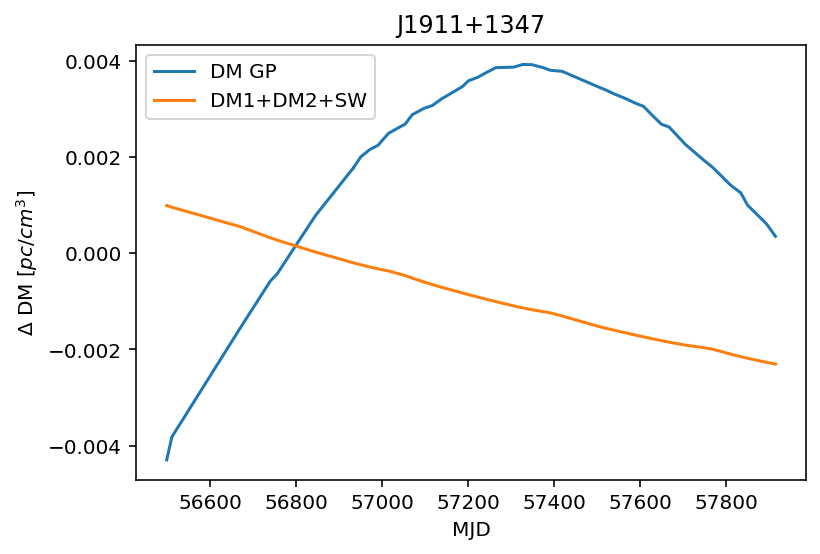

In [30]:
# plt.plot(psr.toas/(24*3600),(mlv_sw*psr.freqs**2*2.41e-4),label='SW')
plt.plot(psr.toas/(24*3600),(mlv_dmgp*psr.freqs**2*2.41e-4),label='DM GP')
plt.plot(psr.toas/(24*3600),(mlvDM*psr.freqs**2*2.41e-4),label='DM1+DM2+SW')
# plt.plot(psr.toas/(24*3600),(mlv_sgp*psr.freqs**4*2.41e-10),label='Scatt')
# plt.plot(psr.toas/(24*3600),((mlv_dmgp+mlvDM)*psr.freqs**2*2.41e-4),label='DMGP+DM1+DM2+SW')
# plt.ylim(-10,10)
plt.legend()#loc='lower left')
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

## Plot DMX
Use the DMX values from the data release as a comparison of how well the DM GP models are matching the changes in the dispersion measure.

In [31]:
#Load DMX values
dtypes = {'names': ('DMXEP', 'DMX_value', 'DMX_var_err', 
                    'DMXR1', 'DMXR2', 'DMXF1', 
                    'DMXF2', 'DMX_bin'),
          'formats': ('f4','f4','f4','f4','f4','f4','f4','U6')}
dmx = np.loadtxt('./dmx/{0}_NANOGrav_12yv3.dmx'.format(psrname),
                 skiprows=4,
                 dtype=dtypes)

In [32]:
# Convert signals into units of DM [pc/cm^3]
dm_units = (dm_gp + DM)*psr.freqs[np.newaxis,:]**2*2.41e-4 
dm_mlv = (mlvDM + mlv_dmgp)*psr.freqs**2*2.41e-4

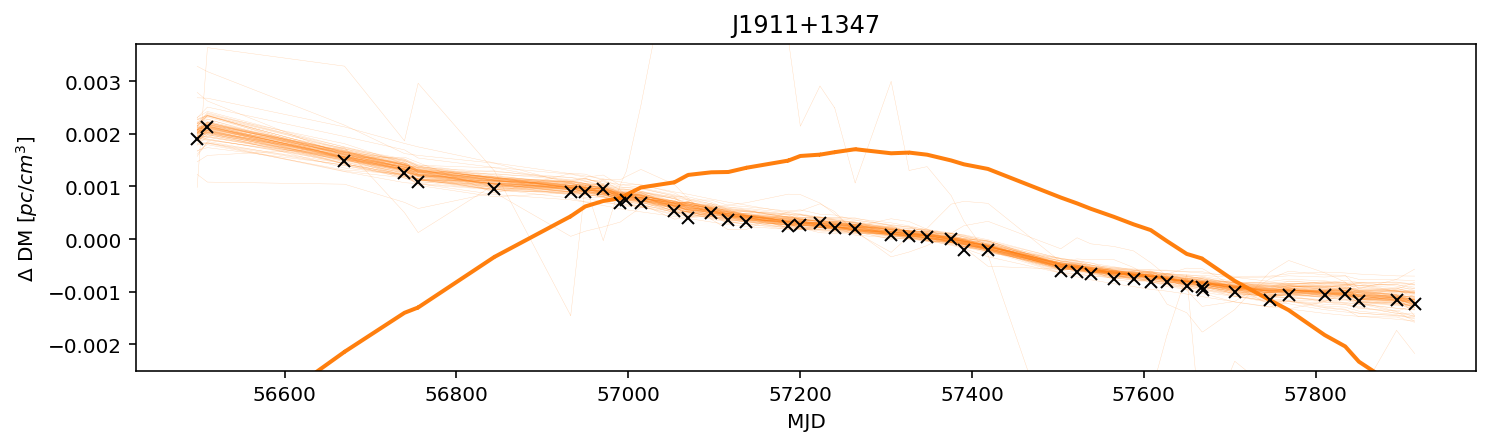

In [33]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mlv-dm_mlv.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

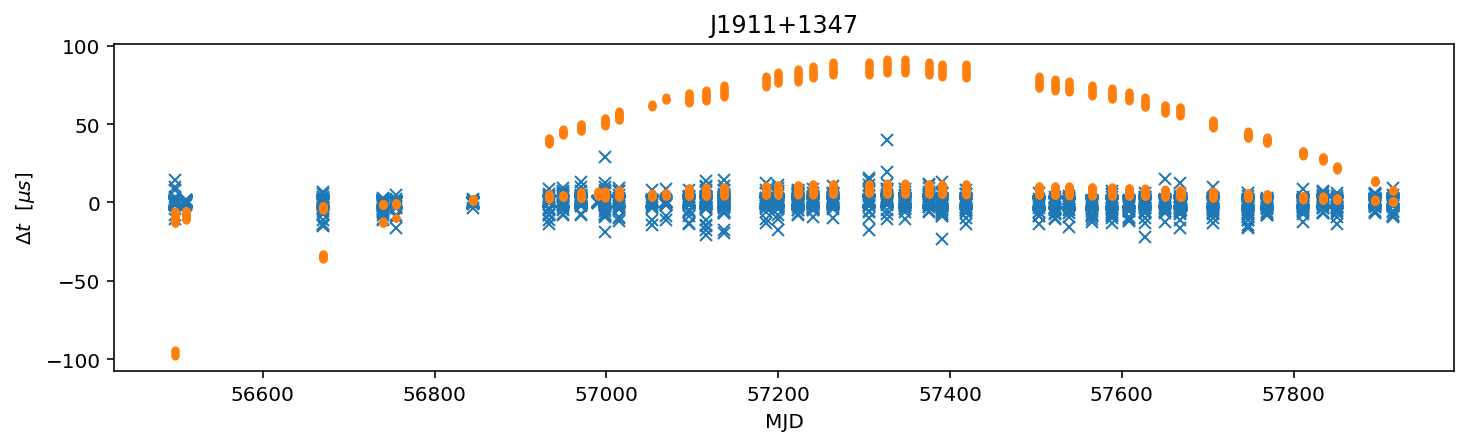

In [34]:
quadDM_resids = psr.residuals-mlvDM-(psr.residuals-mlvDM).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600), quadDM_resids*1e6, 'x')
plt.plot(psr.toas/(24*3600), (mlv_dmgp)*1e6, '.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()

In [35]:
mlv_sw =sr.reconstruct_signal(gp_type='none',det_signal=True, mlv=True)[psrname]

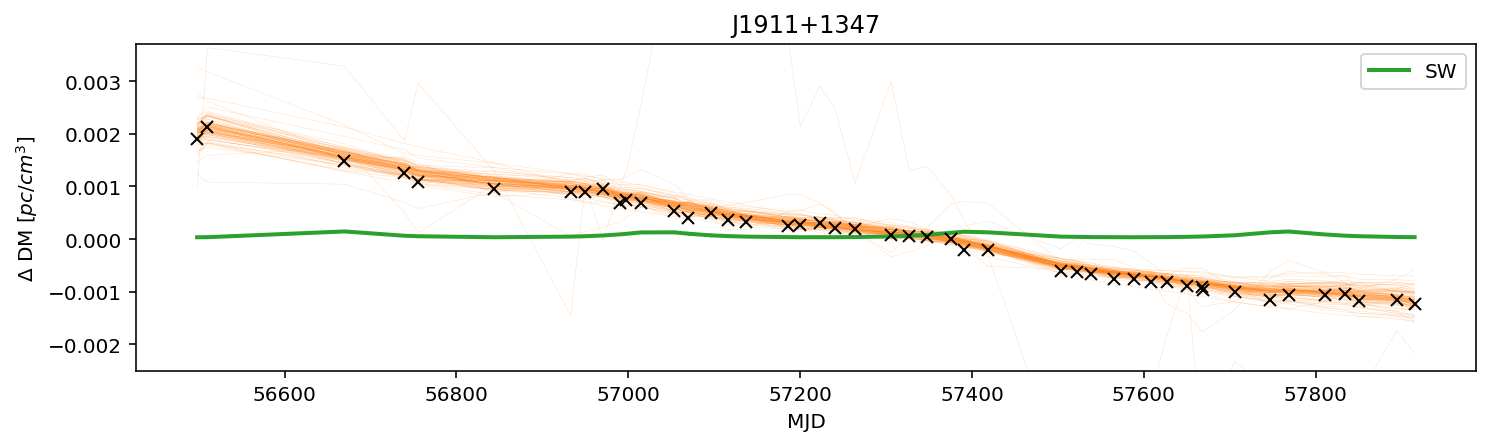

In [36]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),2*mlv_sw*psr.freqs**2*2.41e-4 ,linewidth=2,color='C2',label='SW')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.legend(loc='upper right')
plt.title(psrname)
plt.show()

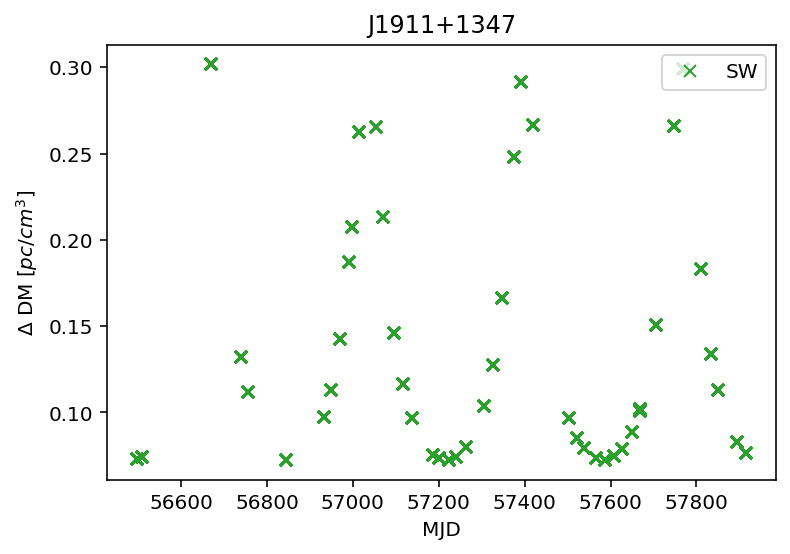

In [37]:
plt.plot(psr.toas/(24*3600),mlv_sw*psr.freqs**2 ,'x',linewidth=2,color='C2',label='SW')
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.legend(loc='upper right')
plt.title(psrname)
plt.show()

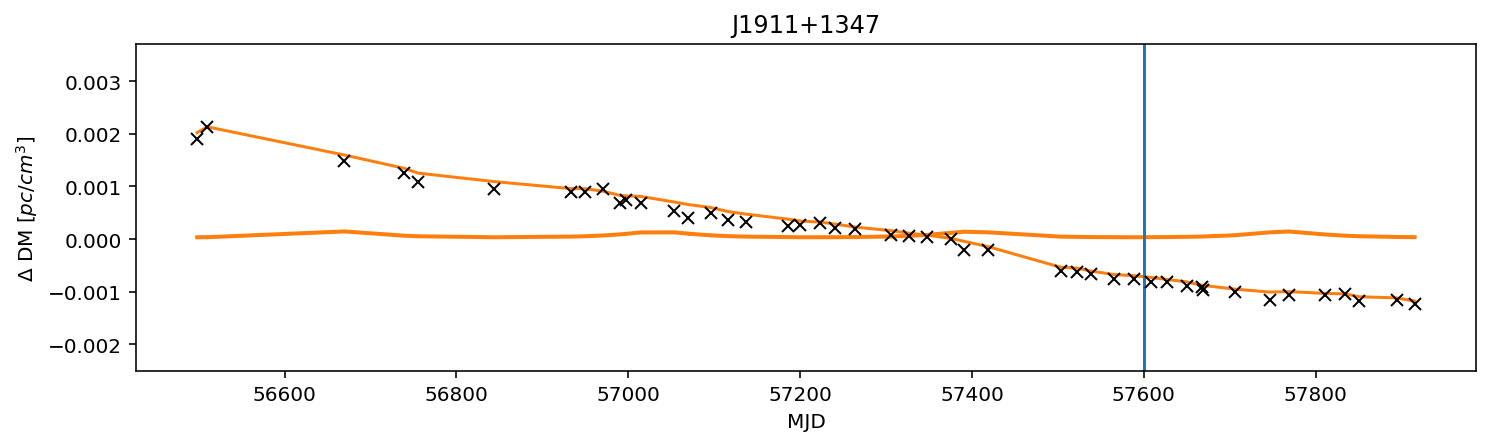

In [38]:
plt.figure(figsize=[12,3])
# for dm in dm_units:
plt.plot(psr.toas/(24*3600),np.mean(dm_units-dm_units.mean(),axis=0),color='C1')

plt.plot(psr.toas/(24*3600),2*mlv_sw*psr.freqs**2*2.41e-4 ,linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.axvline(57600)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

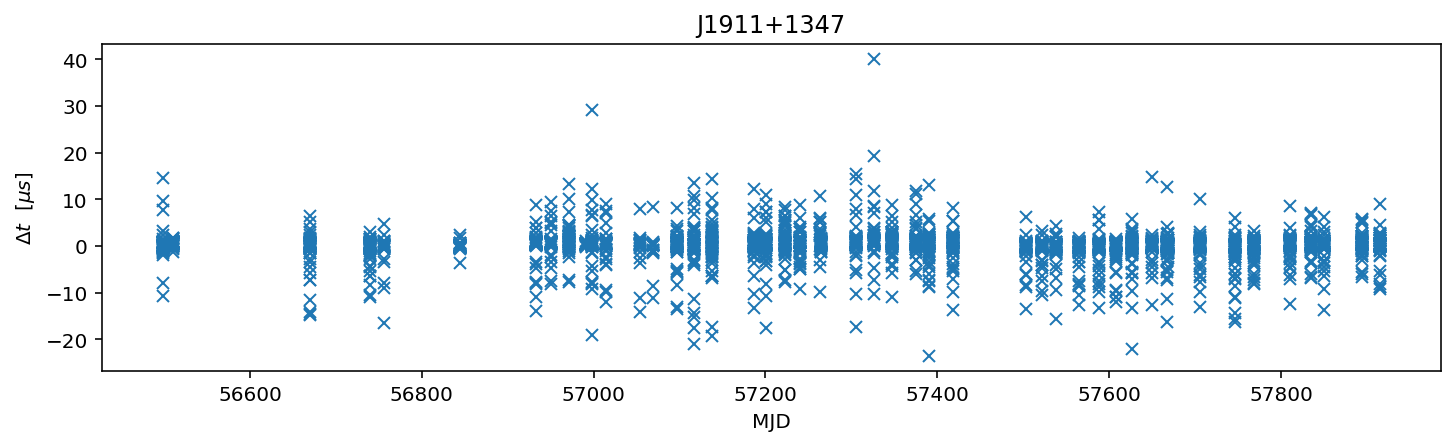

In [39]:
quadDM_resids = psr.residuals-mlvDM-(psr.residuals-mlvDM).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600), quadDM_resids*1e6, 'x')
# plt.plot(psr.toas/(24*3600), (mlv_dmgp+mlv_sgp)*1e6, '.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()

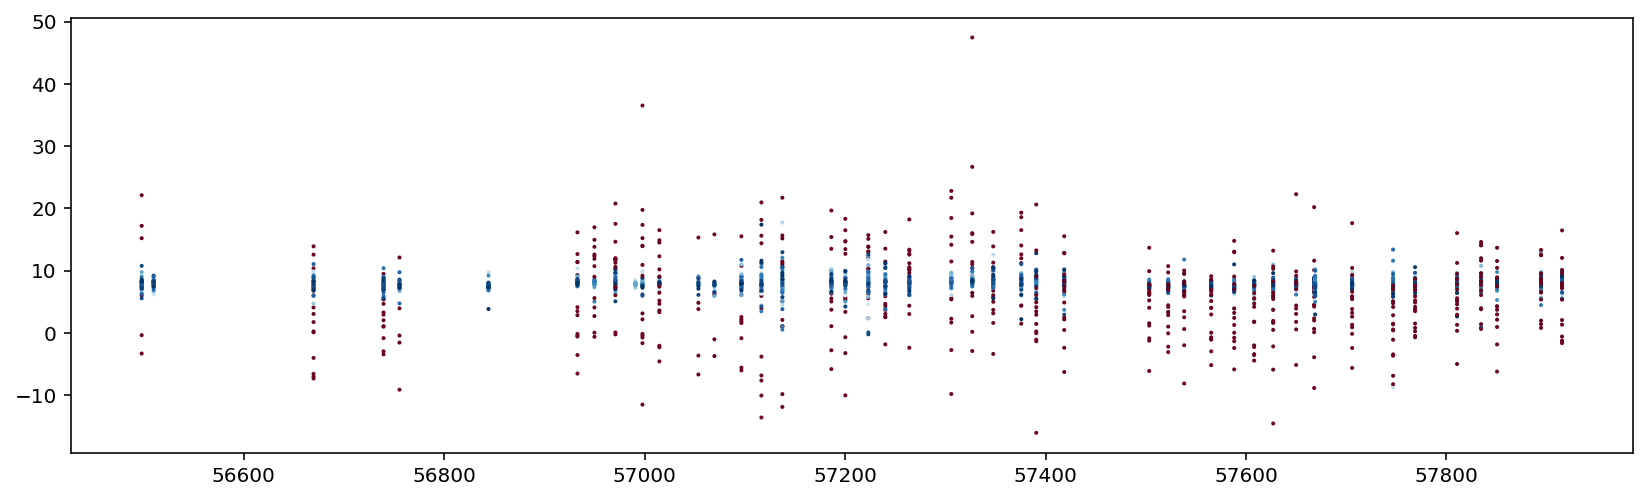

In [40]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=(psr.residuals-mlvDM)*1e6,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

In [41]:
# chrom_gp_mean = np.mean(chrom_gp,axis=0)

In [42]:
# plt.figure(figsize=[14,4])
# plt.plot(psr.toas/sec_to_day,np.mean(chrom_gp,axis=0)*(psr.freqs/1400)**4,'.')

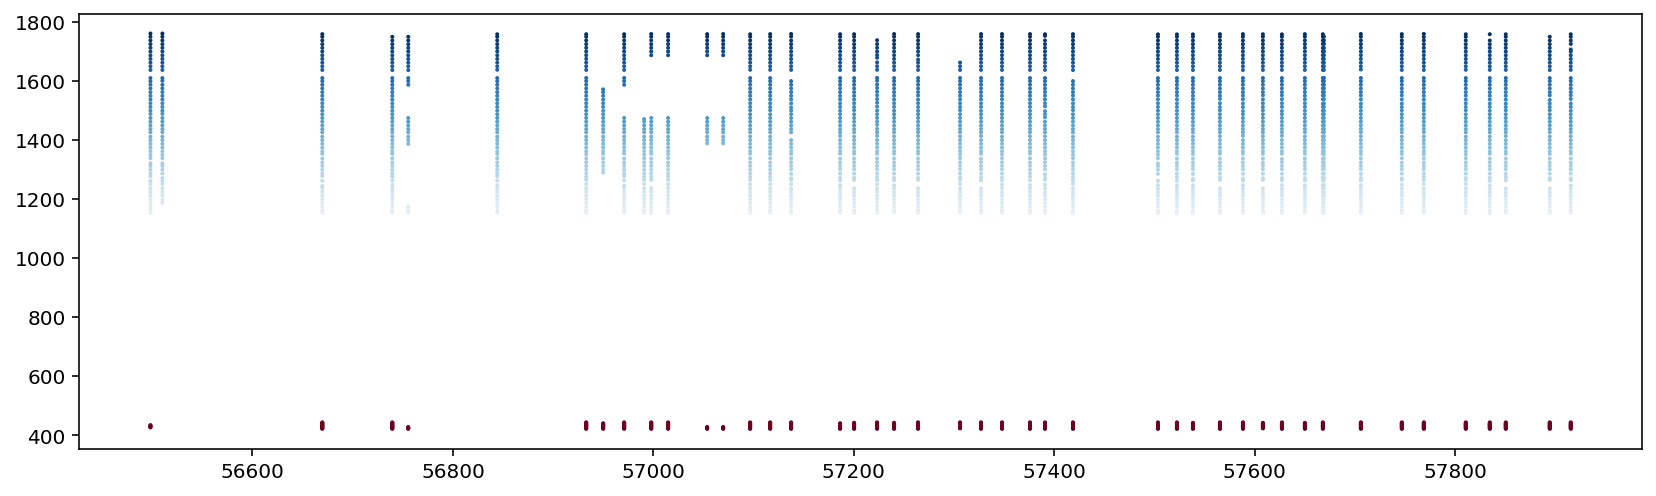

In [43]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=psr.freqs,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

In [44]:
resids,msks=epoch_ave_resid(psr, correction=mlvDM)

In [45]:
# resids2,msks2=epoch_ave_resid(psr, correction=(mlvDM+chrom_gp_mean))

In [46]:
msks.keys()

dict_keys(['430', 'L-wide'])

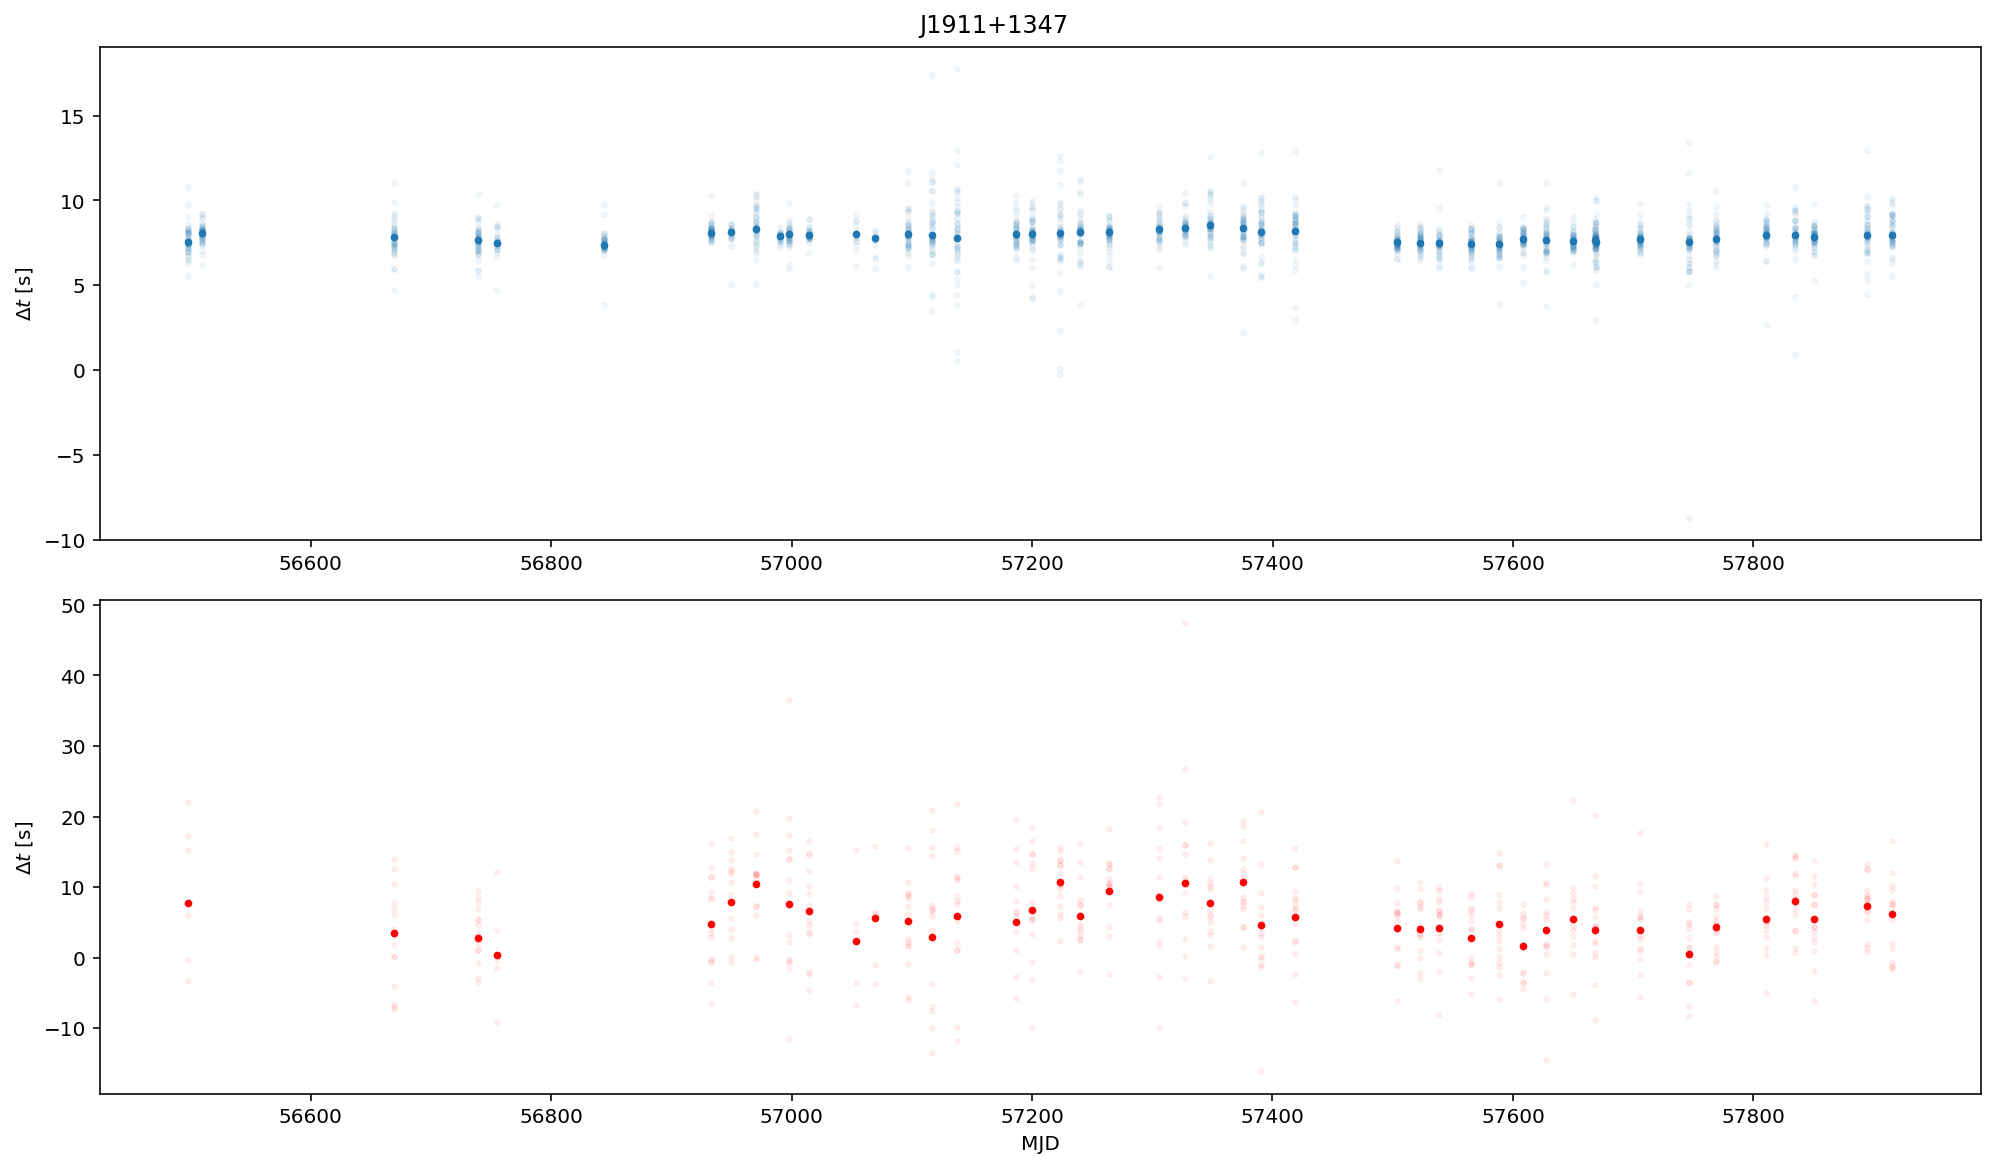

In [47]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(211)
high_rec = 'L-wide' #'Rcvr1_2'
plt.scatter(x=resids[high_rec][:,0]/sec_to_day,
            y=resids[high_rec][:,1]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[msks[high_rec]]/sec_to_day,
            y=(psr.residuals-mlvDM)[msks[high_rec]]*1e6,
            s=6,
            c='C0',alpha=0.05)
# plt.ylim(-7.5,5)
# plt.xlim(56400,56600)
plt.ylabel(r'$\Delta t$ [s]')
# plt.axvline(57600,linestyle='--',color='k')

fig.add_subplot(212)
low_rec = '430'#'Rcvr_800'
plt.scatter(x=resids[low_rec][:,0]/sec_to_day,
            y=resids[low_rec][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[msks[low_rec]]/sec_to_day,
            y=(psr.residuals-mlvDM)[msks[low_rec]]*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
# plt.xlim(56400,56600)
# plt.axvline(57600,linestyle='--',color='k')
# plt.ylim(-12,12)

plt.ylabel(r'$\Delta t$ [s]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

In [48]:
# sec_to_day = 24*3600
# fig=plt.figure(figsize=[14,8])
# fig.add_subplot(211)
# plt.scatter(x=resids2['Rcvr1_2'][:,0]/sec_to_day,
#             y=resids2['Rcvr1_2'][:,1]*1e6,
#             s=8, c='C0')
# plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr1_2']/sec_to_day,
#             y=(psr.residuals-mlvDM-chrom_gp_mean)[psr.flags['fe']=='Rcvr1_2']*1e6,
#             s=6,
#             c='C0',alpha=0.05)
# plt.ylim(-7.5,5)
# # plt.xlim(56400,56600)
# plt.ylabel(r'$\Delta t$ [s]')
# plt.axvline(57600,linestyle='--',color='k')

# fig.add_subplot(212)

# plt.scatter(x=resids2['Rcvr_800'][:,0]/sec_to_day,
#             y=resids2['Rcvr_800'][:,1]*1e6,
#             s=8,c='red')
# plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr_800']/sec_to_day,
#             y=(psr.residuals-mlvDM-chrom_gp_mean)[psr.flags['fe']=='Rcvr_800']*1e6,
#             s=6,
#             c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# # plt.xlim(57000,58000)
# # plt.xlim(56400,56600)
# plt.axvline(57600,linestyle='--',color='k')
# plt.ylim(-12,12)

# plt.ylabel(r'$\Delta t$ [s]')
# plt.xlabel('MJD')
# fig.suptitle(psrname,y=1.01)
# fig.tight_layout()
# plt.show()

In [49]:
# sec_to_day = 24*3600
# fig=plt.figure(figsize=[14,8])
# fig.add_subplot(311)
# plt.scatter(x=resids['Rcvr1_2'][:,0]/sec_to_day,
#             y=resids['Rcvr1_2'][:,1]*1e6,
#             s=8,c='C0')
# plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr1_2']/sec_to_day,
#             y=(psr.residuals-mlvDM)[psr.flags['fe']=='Rcvr1_2']*1e6,
#             s=6,
#             c='C0',alpha=0.05)
# plt.ylim(-7.5,5)
# plt.ylabel(r'$\Delta t$ [s]')
# plt.axvline(57600,linestyle='--',color='k')
# plt.axvline(57250,linestyle='--',color='k')

# fig.add_subplot(312)
# plt.scatter(x=resids['Rcvr_800'][:,0]/sec_to_day,
#             y=resids['Rcvr_800'][:,1]*1e6,
#             s=8,c='red')
# plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr_800']/sec_to_day,
#             y=(psr.residuals-mlvDM)[psr.flags['fe']=='Rcvr_800']*1e6,
#             s=6,
#             c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# # plt.xlim(57000,58000)
# plt.axvline(57600,linestyle='--',color='k')
# plt.ylim(-12,10)

# plt.ylabel(r'$\Delta t$ [s]')
# plt.xlabel('MJD')

# fig.add_subplot(313)
# plt.plot(psr.toas/sec_to_day,np.mean(chrom_gp,axis=0)*(psr.freqs/1400)**4,'x',color='k')
# plt.axvline(57600,linestyle='--',color='k')
# plt.axvline(57250,linestyle='--',color='k')
# plt.ylabel(r'$\Delta t$ Scattering [s]')
# fig.suptitle(psrname,y=1.01)
# fig.tight_layout(pad=1.01)
# plt.show()



